In [1]:
!pip -q install --upgrade transformers datasets evaluate rouge-score accelerate


In [2]:
import pandas as pd
import numpy as np
import time
import torch
import evaluate
from datasets import load_dataset
from transformers import pipeline, AutoModelForSeq2SeqLM


In [3]:
dataset = load_dataset("cnn_dailymail", "3.0.0", split="test[:120]")
rouge = evaluate.load("rouge")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
def filter_domain(data, keywords, limit=10):
    result = []
    for item in data:
        text = item["article"].lower()
        if any(k in text for k in keywords):
            result.append(item)
        if len(result) >= limit:
            break
    return result

politics_data = filter_domain(dataset, ["government","election","minister","policy"])
sports_data   = filter_domain(dataset, ["match","team","goal","league","tournament"])
health_data   = filter_domain(dataset, ["health","doctor","hospital","medical","disease"])

domains = {
    "Politics": politics_data,
    "Sports": sports_data,
    "Health": health_data
}


In [5]:
models = {
    "BART": "facebook/bart-large-cnn",
    "T5": "t5-small",
    "DistilBART": "sshleifer/distilbart-cnn-12-6"
}


In [6]:
def get_model_size(model_name):
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
    return round(sum(p.numel() for p in model.parameters())/1e6,2)

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

def evaluate_model(model_id, data):

    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_id)

    if torch.cuda.is_available():
        model = model.to("cuda")

    preds, refs = [], []
    start = time.time()

    for item in data:
        text = item["article"][:700]

        # T5 needs prefix
        if "t5" in model_id.lower():
            text = "summarize: " + text

        inputs = tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            max_length=512
        )

        if torch.cuda.is_available():
            inputs = {k: v.to("cuda") for k, v in inputs.items()}

        summary_ids = model.generate(
            inputs["input_ids"],
            max_length=120,
            min_length=30,
            num_beams=4
        )

        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

        preds.append(summary)
        refs.append(item["highlights"])

    end = time.time()

    score = rouge.compute(predictions=preds, references=refs)
    avg_time = (end - start)/len(data)

    return score["rougeL"], avg_time


In [7]:
results = []

for domain, data in domains.items():
    for name, model_id in models.items():
        print(f"Running {name} on {domain}")
        rouge_l, avg_time = evaluate_model(model_id, data)
        size = get_model_size(model_id)

        results.append([domain, name, rouge_l, avg_time, size])

df = pd.DataFrame(results, columns=["Domain","Model","ROUGE","Time","Size"])
df


Running BART on Politics


Please make sure the generation config includes `forced_bos_token_id=0`. 


Loading weights:   0%|          | 0/511 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/511 [00:00<?, ?it/s]

Running T5 on Politics


Loading weights:   0%|          | 0/131 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/131 [00:00<?, ?it/s]

Running DistilBART on Politics


Loading weights:   0%|          | 0/358 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie model.shared.weight to model.decoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie model.shared.weight to model.encoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


Loading weights:   0%|          | 0/358 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie model.shared.weight to model.decoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie model.shared.weight to model.encoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


Running BART on Sports


Loading weights:   0%|          | 0/511 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/511 [00:00<?, ?it/s]

Running T5 on Sports


Loading weights:   0%|          | 0/131 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/131 [00:00<?, ?it/s]

Running DistilBART on Sports


Loading weights:   0%|          | 0/358 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie model.shared.weight to model.decoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie model.shared.weight to model.encoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


Loading weights:   0%|          | 0/358 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie model.shared.weight to model.decoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie model.shared.weight to model.encoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


Running BART on Health


Loading weights:   0%|          | 0/511 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/511 [00:00<?, ?it/s]

Running T5 on Health


Loading weights:   0%|          | 0/131 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/131 [00:00<?, ?it/s]

Running DistilBART on Health


Loading weights:   0%|          | 0/358 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie model.shared.weight to model.decoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie model.shared.weight to model.encoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


Loading weights:   0%|          | 0/358 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie model.shared.weight to model.decoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie model.shared.weight to model.encoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


,Domain,Model,ROUGE,Time,Size
0,Politics,BART,0.250736,10.349811,406.29
1,Politics,T5,0.159127,3.796783,60.51
2,Politics,DistilBART,0.208916,7.220955,408.45
3,Sports,BART,0.226362,9.526490,406.29
4,Sports,T5,0.193629,2.870076,60.51
5,Sports,DistilBART,0.180290,6.356631,408.45
6,Health,BART,0.274426,9.404656,406.29
7,Health,T5,0.189023,2.945856,60.51
8,Health,DistilBART,0.276974,6.305591,408.45


In [8]:
def topsis(matrix, weights, impacts):
    matrix = np.array(matrix, dtype=float)

    norm = matrix / np.sqrt((matrix**2).sum(axis=0))
    weighted = norm * weights

    ideal_best = weighted.max(axis=0)
    ideal_worst = weighted.min(axis=0)

    for i, imp in enumerate(impacts):
        if imp == '-':
            ideal_best[i], ideal_worst[i] = ideal_worst[i], ideal_best[i]

    d_best = np.sqrt(((weighted - ideal_best)**2).sum(axis=1))
    d_worst = np.sqrt(((weighted - ideal_worst)**2).sum(axis=1))

    return d_worst / (d_best + d_worst)


In [9]:
final_tables = []

for domain in df["Domain"].unique():
    temp = df[df["Domain"] == domain].copy()
    matrix = temp[["ROUGE","Time","Size"]].values

    weights = np.array([0.5,0.25,0.25])
    impacts = ['+','-','-']

    scores = topsis(matrix, weights, impacts)

    temp["TOPSIS_Score"] = scores
    temp["Rank"] = temp["TOPSIS_Score"].rank(ascending=False)

    final_tables.append(temp)

final_df = pd.concat(final_tables)
final_df


,Domain,Model,ROUGE,Time,Size,TOPSIS_Score,Rank
0,Politics,BART,0.250736,10.349811,406.29,0.393768,2.0
1,Politics,T5,0.159127,3.796783,60.51,0.607118,1.0
2,Politics,DistilBART,0.208916,7.220955,408.45,0.343330,3.0
3,Sports,BART,0.226362,9.526490,406.29,0.243764,3.0
4,Sports,T5,0.193629,2.870076,60.51,0.814824,1.0
5,Sports,DistilBART,0.180290,6.356631,408.45,0.271684,2.0
6,Health,BART,0.274426,9.404656,406.29,0.326509,3.0
7,Health,T5,0.189023,2.945856,60.51,0.667727,1.0
8,Health,DistilBART,0.276974,6.305591,408.45,0.421324,2.0


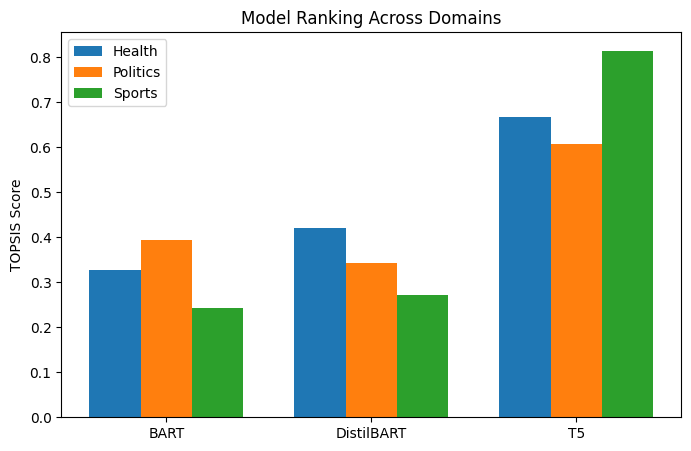

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Pivot data: rows = Models, columns = Domains
pivot_df = final_df.pivot(index="Model", columns="Domain", values="TOPSIS_Score")

models = pivot_df.index
domains = pivot_df.columns

x = np.arange(len(models))   # model positions
width = 0.25                 # bar width

plt.figure(figsize=(8,5))

for i, domain in enumerate(domains):
    plt.bar(x + i*width, pivot_df[domain], width, label=domain)

plt.xticks(x + width, models)
plt.ylabel("TOPSIS Score")
plt.title("Model Ranking Across Domains")
plt.legend()
plt.show()
